In [1]:
import geopandas as gpd
import rioxarray as rxr
from rasterstats import zonal_stats
import pandas as pd
import os
import rasterio
from rasterio.mask import mask
import numpy as np
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from rasterio.features import rasterize
from data_utils import best_res_align, align_r1_to_r2
import xarray as xr
import pyreadr

## checking my climate statistic calculations are consistent with andra

In [2]:
# laptop folder
folder = "../../_data/p-dengue/"
valid_admin2 = pd.read_csv(os.path.join(folder, 'valid_admin/valid_admin2.csv'), header=None)[0].tolist()
valid_admin1 = pd.read_csv(os.path.join(folder, 'valid_admin/valid_admin1.csv'), header=None)[0].tolist()
valid_admin2.sort()
valid_admin1.sort()

In [3]:
admin1_year_month_climate = pd.read_csv(os.path.join(folder, 'admin_year_month_climate_statistics/admin1_year_month_climate_statistics.csv'))

In [4]:
admin1_year_month_climate = admin1_year_month_climate[admin1_year_month_climate['year'] > 2023].sort_values(['admin1', 'year', 'month']).reset_index(drop=True)

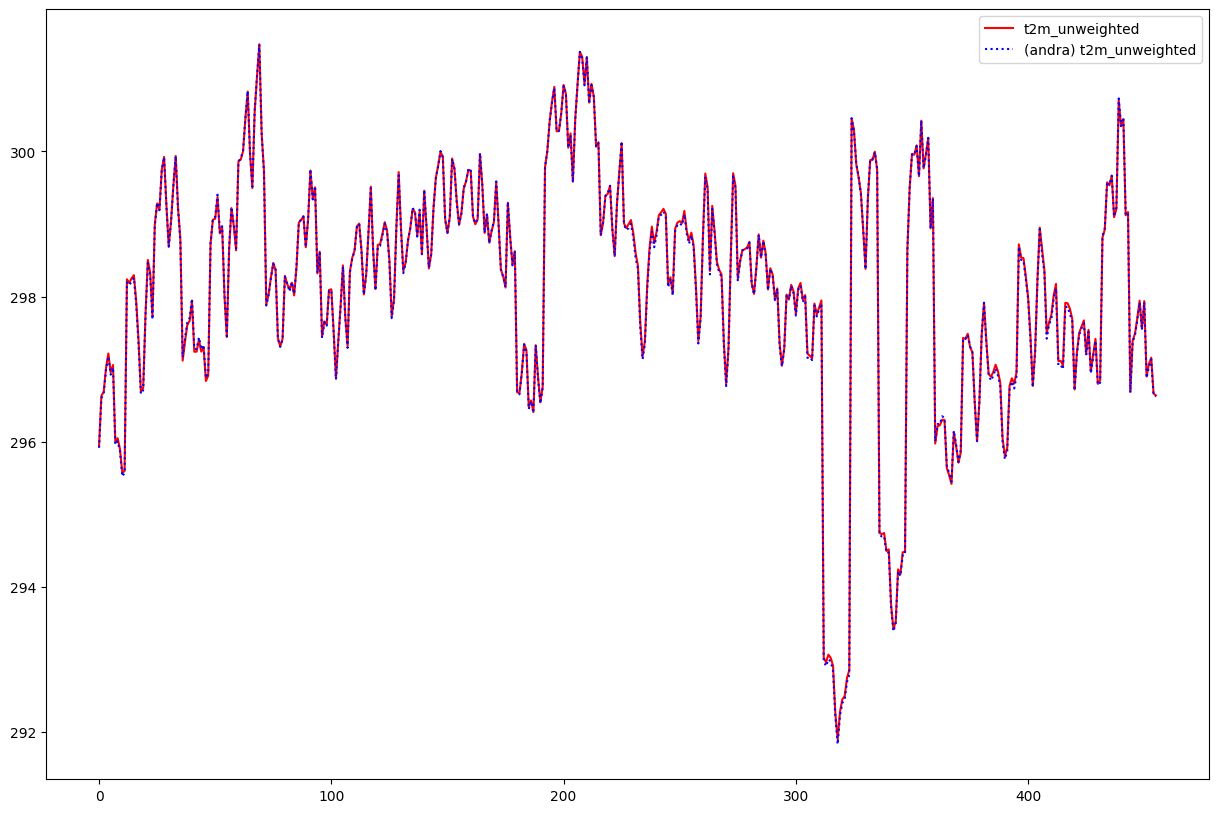

In [5]:
# temperature
a_admin1_year_month_climate = pyreadr.read_r(os.path.join(folder, 'dengue_indonesia_yifan/data/temp_monthly_admin1.rds'))[None]
a_admin1_year_month_climate['date'] = pd.to_datetime(a_admin1_year_month_climate['date'])
a_admin1_year_month_climate = a_admin1_year_month_climate[a_admin1_year_month_climate['date'] > '2023-12-31'][['admin1', 'date', 'mean', 'weighted_mean']].sort_values(['admin1', 'date']).reset_index(drop=True)

plt.figure(figsize=(15,10))
plt.plot(admin1_year_month_climate[['t2m_mean_unweighted']], label='t2m_unweighted', c='red')
# plt.plot(admin1_year_month_climate[['t2m_mean_pop_weighted']], label='t2m_weighted', c='orange')
plt.plot(a_admin1_year_month_climate[['mean']], label='(andra) t2m_unweighted', c='blue', linestyle=':')
# plt.plot(a_admin1_year_month_climate[['weighted_mean']], label='(andra)t2m_weighted', c='green', linestyle=':')
plt.legend()
plt.show()

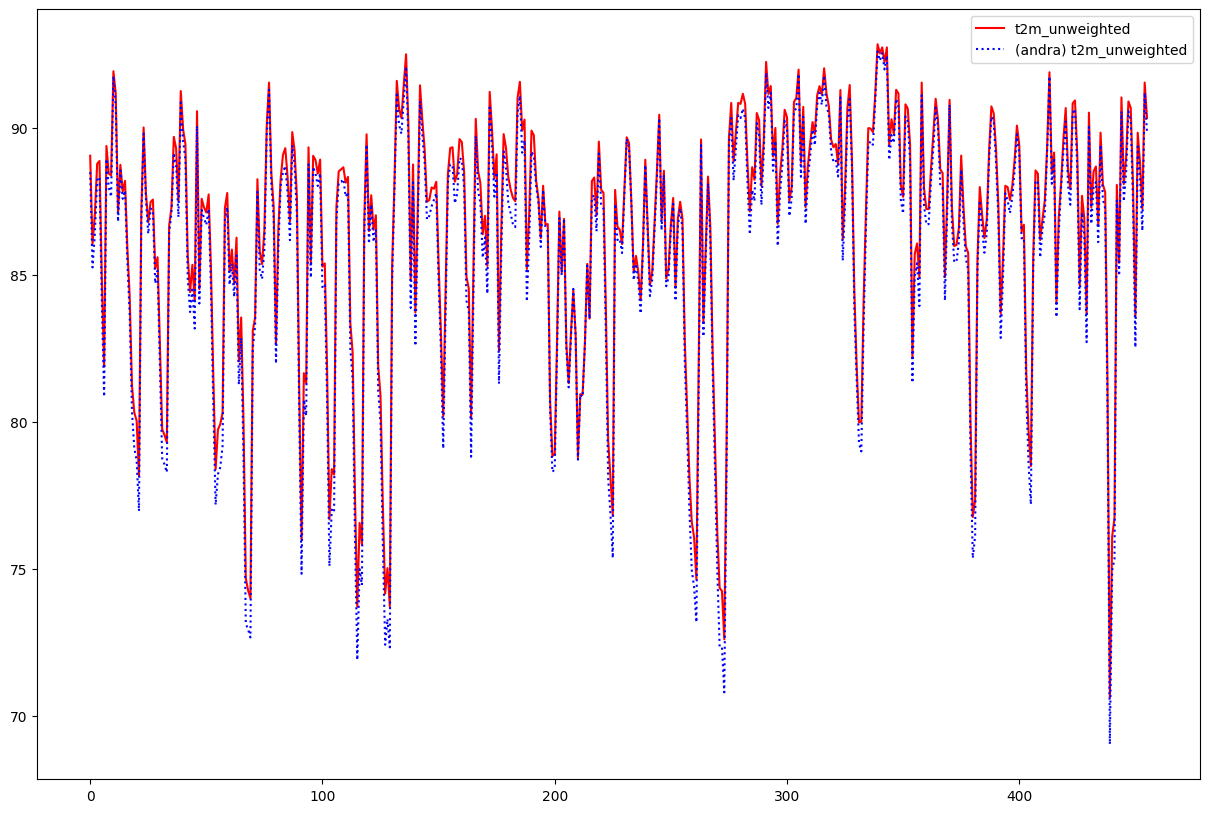

In [6]:
# relative humidity
a_admin1_year_month_climate = pyreadr.read_r(os.path.join(folder, 'dengue_indonesia_yifan/data/humid_monthly_admin1.rds'))[None]
a_admin1_year_month_climate['date'] = pd.to_datetime(a_admin1_year_month_climate['date'])
a_admin1_year_month_climate = a_admin1_year_month_climate[a_admin1_year_month_climate['date'] > '2023-12-31'][['admin1', 'date', 'mean', 'weighted_mean']].sort_values(['admin1', 'date']).reset_index(drop=True)

plt.figure(figsize=(15,10))
plt.plot(admin1_year_month_climate[['rh_mean_unweighted']], label='t2m_unweighted', c='red')
# plt.plot(admin1_year_month_climate[['rh_mean_pop_weighted']], label='t2m_weighted', c='orange')
plt.plot(a_admin1_year_month_climate[['mean']], label='(andra) t2m_unweighted', c='blue', linestyle=':')
# plt.plot(a_admin1_year_month_climate[['weighted_mean']], label='(andra)t2m_weighted', c='green', linestyle=':')
plt.legend()
plt.show()

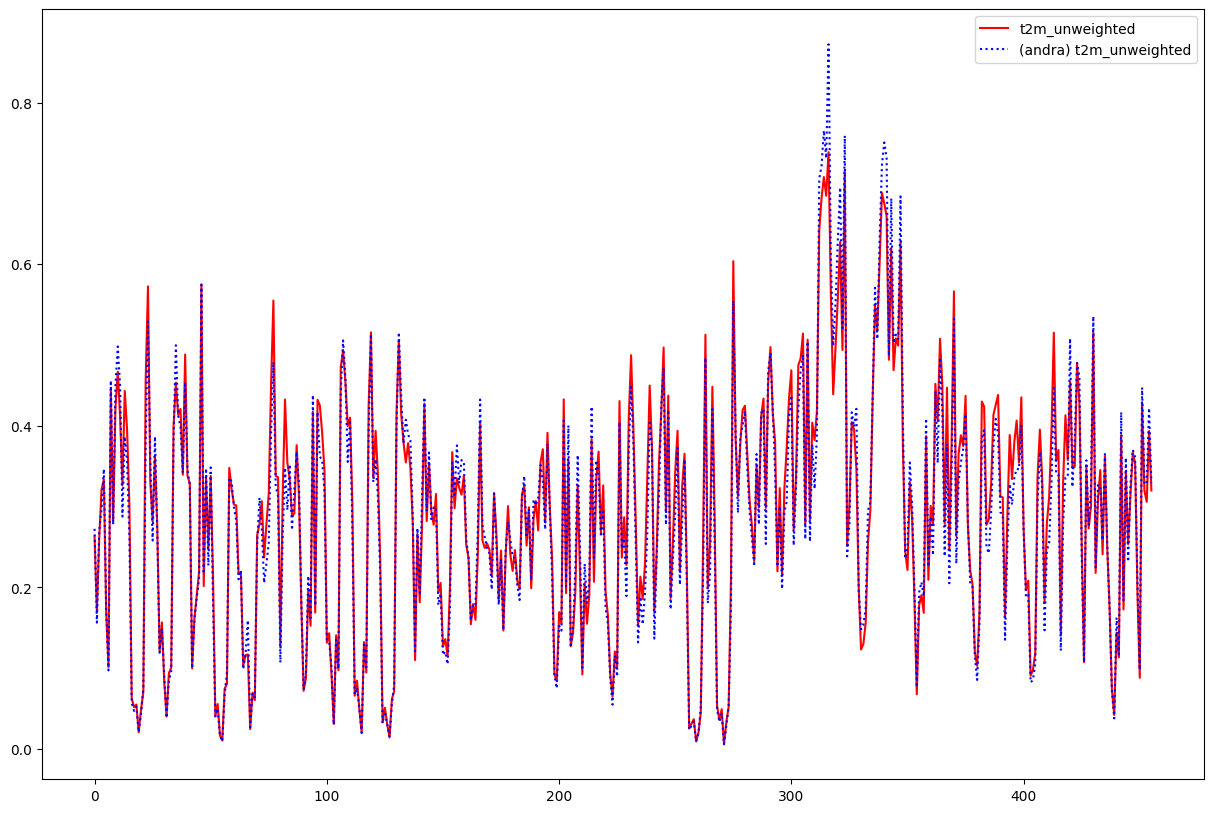

In [7]:
# precipitation
a_admin1_year_month_climate = pyreadr.read_r(os.path.join(folder, 'dengue_indonesia_yifan/data/prec_monthly_admin1.rds'))[None]
a_admin1_year_month_climate['date'] = pd.to_datetime(a_admin1_year_month_climate['date'])
a_admin1_year_month_climate = a_admin1_year_month_climate[a_admin1_year_month_climate['date'] > '2023-12-31'][['admin1', 'date', 'mean', 'weighted_mean']].sort_values(['admin1', 'date']).reset_index(drop=True)

plt.figure(figsize=(15,10))
plt.plot(admin1_year_month_climate[['tp_mean_unweighted']]/0.019387861799173903, label='t2m_unweighted', c='red')
# plt.plot(admin1_year_month_climate[['tp_mean_pop_weighted']]/0.019387861799173903, label='t2m_weighted', c='orange')
plt.plot(a_admin1_year_month_climate[['mean']], label='(andra) t2m_unweighted', c='blue', linestyle=':')
# plt.plot(a_admin1_year_month_climate[['weighted_mean']], label='(andra)t2m_weighted', c='green', linestyle=':')
plt.legend()
plt.show()

---

### Pop

In [13]:
admin2_year_pop = pd.read_csv(os.path.join(folder, 'admin_year_pop/admin2_year_pop.csv'))

In [30]:
admin2_year_pop = admin2_year_pop.loc[admin2_year_pop['year']>2015, :].sort_values(['admin2', 'year']).reset_index(drop=True)

In [31]:
d_incidence = pyreadr.read_r(os.path.join(folder, 'dengue_indonesia_yifan/data/data_cases_deaths_pop_2016_2024_38.rds'))[None]
d_incidence = (d_incidence[d_incidence["admin2"].isin(valid_admin2)].sort_values("admin2").reset_index(drop=True))


In [32]:
a_admin2_year_pop = d_incidence[['admin2', 'year', 'pop']].drop_duplicates().reset_index(drop=True)

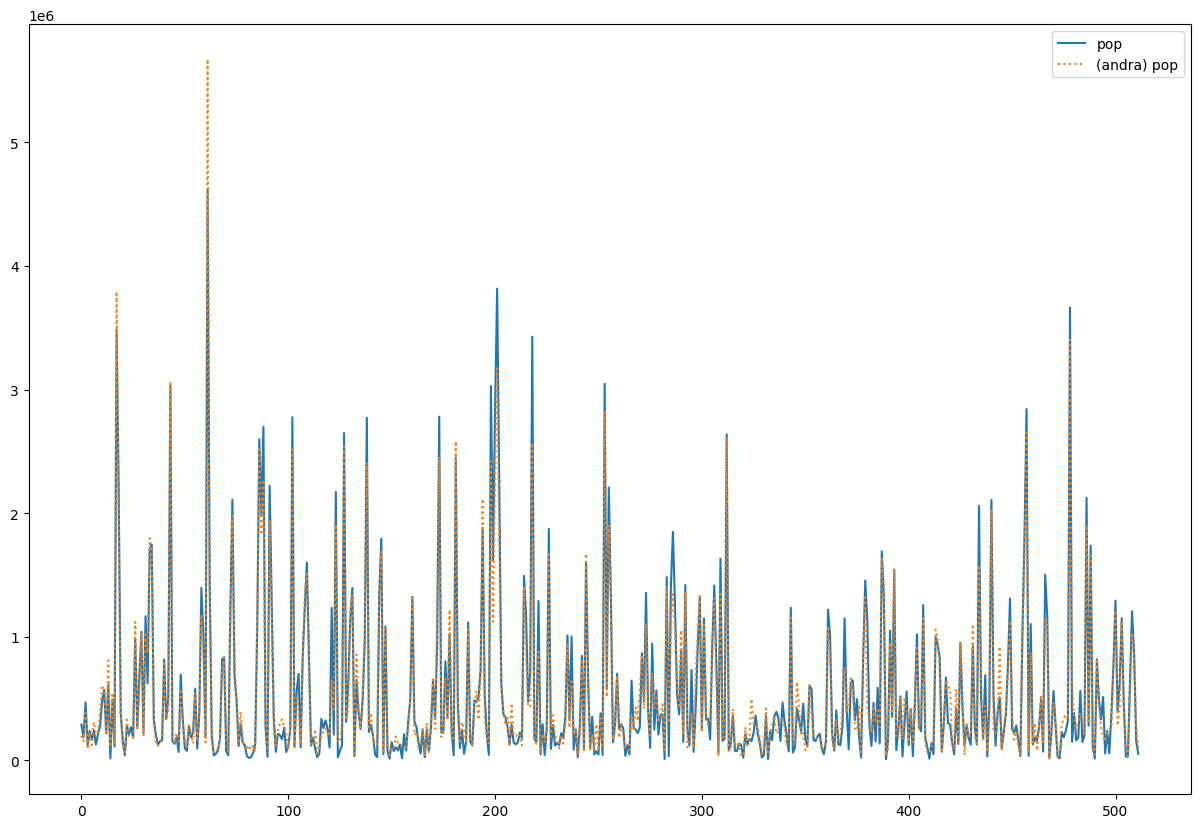

In [69]:
plt.figure(figsize=(15,10))

plt.plot(admin2_year_pop.loc[admin2_year_pop['year']==2016,'population'].reset_index(drop=True), label='pop')
plt.plot(a_admin2_year_pop.loc[admin2_year_pop['year']==2016,'pop'].reset_index(drop=True), label='(andra) pop', linestyle=':')
plt.legend()
plt.show()

This is consistent. From what i understood Andra first aligned population to urbanisation and then calculated population sums within the urbanisation loop. I did it separately on the original alignment. Pop scan has the best resolution so I thought it best to align everything else to it instead for more accurate masking.

### Urban

In [85]:
admin = 1

In [86]:
admin_year_urbanisation = pd.read_csv(os.path.join(folder, f'admin_year_urbanisation/admin{admin}_year_urbanisation.csv'))

In [87]:
admin_year_urbanisation = admin_year_urbanisation.loc[admin_year_urbanisation['year']==2020, :].sort_values([f'admin{admin}', 'year']).reset_index(drop=True)

In [88]:
va = {1: valid_admin1, 2: valid_admin2}

In [89]:
d_urbanisation = pyreadr.read_r(os.path.join(folder,f'dengue_indonesia_yifan/data/urbanisation_admin{admin}.rds'))[None]
m_ = [a in va[admin] for a in d_urbanisation[f'admin{admin}']]
a_admin_year_urbanisation = d_urbanisation.loc[m_, :]
a_admin_year_urbanisation = a_admin_year_urbanisation.sort_values([f'admin{admin}']).reset_index(drop=True)[[f'admin{admin}', 'urban_area_pct_binary', 'urban_pop_pct_binary']]

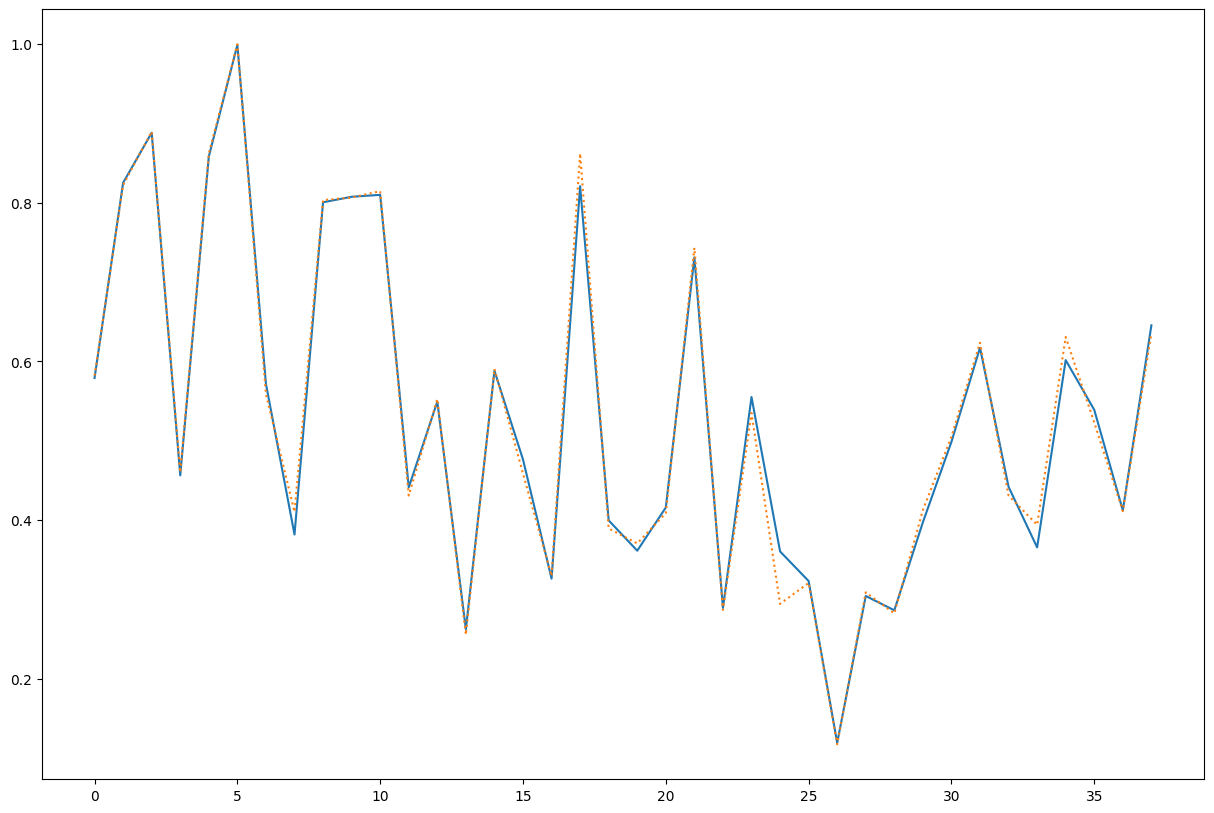

In [90]:
plt.figure(figsize=(15,10))

plt.plot(admin_year_urbanisation['urbanisation_pop_weighted'], label='pop')
plt.plot(a_admin_year_urbanisation['urban_pop_pct_binary']/100, label='(andra) pop', linestyle=':')
plt.show()

### Surveillance

In [103]:
admin = 2

In [104]:
admin_year_surveillance = pd.read_csv(os.path.join(folder, f'admin_year_surveillance/admin{admin}_year_surveillance.csv'))

In [105]:
admin_year_surveillance = admin_year_surveillance.loc[admin_year_surveillance['year']==2020, :].sort_values([f'admin{admin}', 'year']).reset_index(drop=True)

In [106]:
d_surveillance = pyreadr.read_r(os.path.join(folder,f'dengue_indonesia_yifan/data/surveillance_admin{admin}.rds'))[None]
m_ = [a in va[admin] for a in d_surveillance[f'admin{admin}']]
a_admin_year_surveillance = d_surveillance.loc[m_, :]
a_admin_year_surveillance = a_admin_year_surveillance.sort_values([f'admin{admin}']).reset_index(drop=True)[[f'admin{admin}', 'surveillance_area_pct', 'surveillance_pop_pct']]

In [107]:
a_admin_year_surveillance

,admin2,surveillance_area_pct,surveillance_pop_pct
0,ACEH BARAT,37.401369,63.992208
1,ACEH BARAT DAYA,29.938012,74.951720
2,ACEH BESAR,51.961601,85.829312
3,ACEH JAYA,23.910111,57.361519
4,ACEH SELATAN,23.518889,50.176042
...,...,...,...
507,WAY KANAN,51.474440,53.264678
508,WONOGIRI,83.792472,88.806373
509,WONOSOBO,84.936488,89.385170
510,YAHUKIMO,5.732877,6.240387


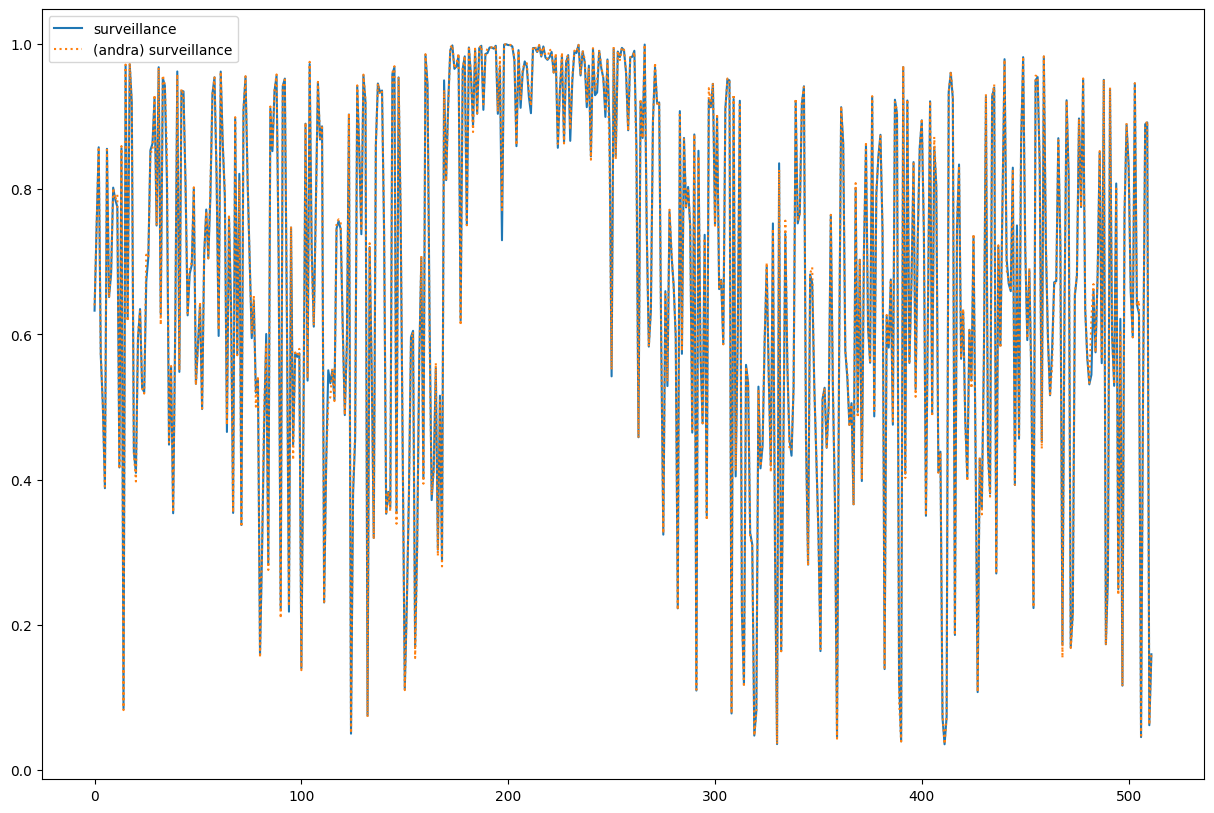

In [108]:
plt.figure(figsize=(15,10))

plt.plot(admin_year_surveillance['surveillance_pop_weighted'], label='surveillance')
plt.plot(a_admin_year_surveillance['surveillance_pop_pct']/100, label='(andra) surveillance', linestyle=':')
plt.legend()
plt.show()